# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Structured Streaming** </center>
---

**Date**: November, 2025

**Student Name**: Ana Carolina Arellano Valdez

**Professor**: Pablo Camarillo Ramirez

# Producer

In [9]:
from carolinarellano.fake_data import FakeDataGenerator

# Initialize the generator
generator = FakeDataGenerator()

events_df = generator.generate_and_save_all(
    n_tracks=250,      
    n_users=50,
    n_events=1000
)

Generating fake data...
Saved tracks.csv with 250 rows to /opt/spark/work-dir/data/carolinarellano/spotify_logs/tracks.csv
Saved user_events.csv with 1000 rows to /opt/spark/work-dir/data/carolinarellano/spotify_logs/user_events.csv
Data generation complete!


In [10]:
!pwd
!ls -l data/carolinarellano/spotify_logs
!head -n 5 data/carolinarellano/spotify_logs/user_events.csv

/opt/spark/work-dir
total 92
-rw-r--r-- 1 root root 13957 Nov 22 06:36 tracks.csv
-rw-r--r-- 1 root root 75351 Nov 22 06:36 user_events.csv
user_id,track_id,event_type,event_ts,session_id,device
user_0007,track_0133,like,2025-09-29 11:33:15.691301,session_000429,tv
user_0028,track_0075,like,2025-09-26 05:51:24.691301,session_001240,tv
user_0019,track_0115,skip,2025-10-21 17:27:02.691301,session_002048,web player
user_0047,track_0083,pause,2025-09-18 00:22:06.691301,session_001725,web player


# Consumer
## Dataset and Stream creation 

In [11]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Structured Streaming - Spotify Logs") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

In [12]:
from carolinarellano.spark_utils import SparkUtils

user_events_schema = SparkUtils.generate_schema([
    ("user_id", "string"),
    ("track_id", "string"),
    ("event_type", "string"),
    ("event_ts", "string"),
    ("session_id", "string"),
    ("device", "string")
])

## Transformations and Actions

In [13]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, year

df = spark \
    .readStream \
    .option("sep", ",") \
    .option("header", "true") \
    .schema(user_events_schema) \
    .csv("data/carolinarellano/spotify_logs/")

# Add a new column with the year extracted from the event_ts column
df_with_year = df.withColumn("year", year(col("event_ts")))
df_with_month = df_with_year.withColumn("month", col("event_ts").substr(6, 2))
df_with_day = df_with_month.withColumn("day", col("event_ts").substr(9, 2))


## Persistence Data

In [14]:
logs_detailed = df_with_day.select("*")
logs_detailed.printSchema()

# Print a few rows to verify
query = logs_detailed \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query.awaitTermination(20)  # Run for 20 seconds
query.stop()

root
 |-- user_id: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_ts: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- device: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)



-------------------------------------------
Batch: 0
-------------------------------------------
+---------+----------+----------+--------------------------+--------------+----------+----+-----+---+
|user_id  |track_id  |event_type|event_ts                  |session_id    |device    |year|month|day|
+---------+----------+----------+--------------------------+--------------+----------+----+-----+---+
|user_0007|track_0133|like      |2025-09-29 11:33:15.691301|session_000429|tv        |2025|09   |29 |
|user_0028|track_0075|like      |2025-09-26 05:51:24.691301|session_001240|tv        |2025|09   |26 |
|user_0019|track_0115|skip      |2025-10-21 17:27:02.691301|session_002048|web player|2025|10   |21 |
|user_0047|track_0083|pause     |2025-09-18 00:22:06.691301|session_001725|web player|2025|09   |18 |
|user_0012|track_0049|pause     |2025-11-13 15:00:19.691301|session_003134|desktop   |2025|11   |13 |
|user_0034|track_0235|skip      |2025-11-14 13:41:35.691301|session_004378|tv        |2

In [ ]:
base_path = "/opt/spark/work-dir/data/"

logs_detailed_query = (
    logs_detailed
        .writeStream
        .trigger(processingTime="10 seconds")
        .partitionBy("year")          
        .outputMode("append")         
        .format("csv")                
        .option("header", "true")     
        .option("path", base_path + "carolinarellano/processed/spotify_logs_detailed_csv/")
        .option("checkpointLocation", base_path + "carolinarellano/checkpoints/spotify_logs_detailed_csv/")
        .start()
)


In [8]:
spark.stop()

## Power BI Dashboard

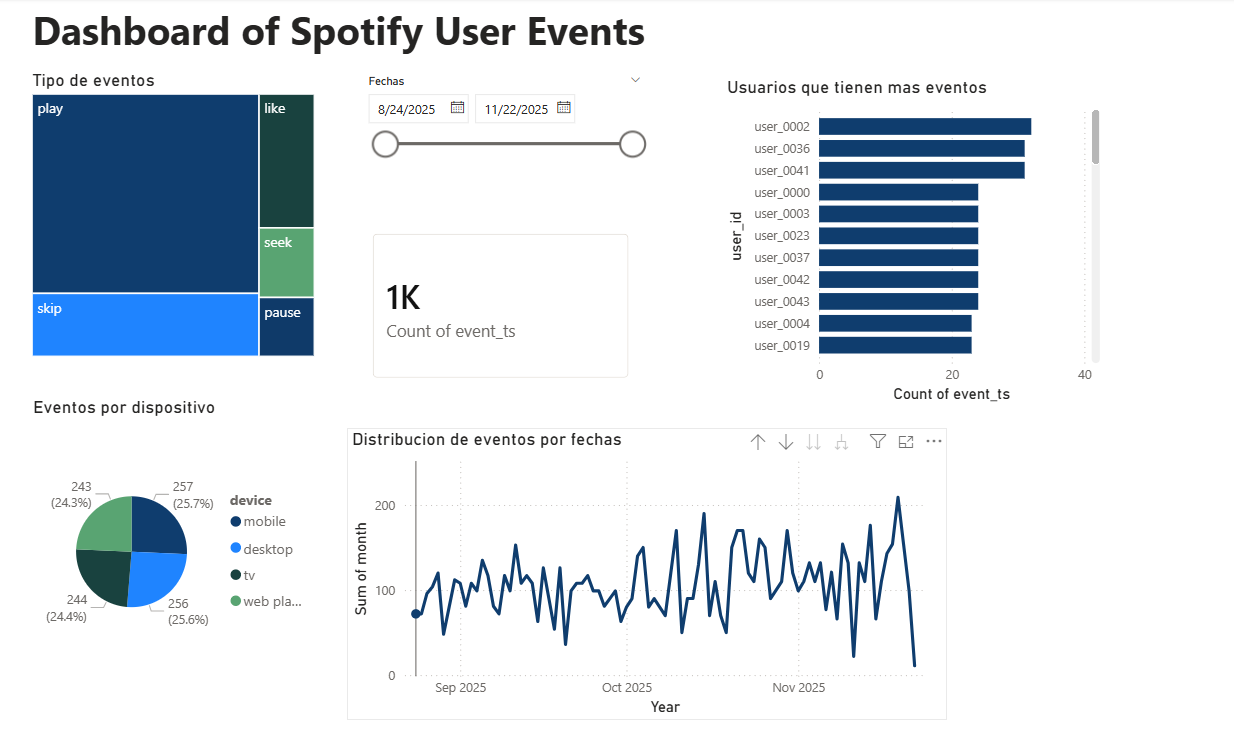